# Blog Post 2: Model Pipeline, Individual Nuclei Segmentation, and Future Work

In this post, we'll go over the following key points:

1. comment on why we're not doing modality separation
1. overview of our current pipeline
    1. discuss our hand designed features
    1. discuss our model choices
    1. discuss our post processing and individual nucleus segmentation
1. discuss our plan moving forward

## about those modalities

In our last post, we did intensive EDA on the different modalities in our training set.  While it ended up being very valuable work for understanding our data, we decided to abandon the separation of modalities here on out.

See [this discussion post](https://www.kaggle.com/c/data-science-bowl-2018/discussion/47640) for some example images of the different training modalities.  In the same post, other Kagglers found that there are **different** modalities in the test set!  And the data curators revealed that there will be even more **different** modalities in the Stage 2 test set!!  As a result, we felt that any model depending on modality metadata would be insufficient for this task, so we are now focusing our efforts on a model that generalizes well for all modalities.

One detail that we have to be careful of, however, is that some modalities have dark nuclei on white backgrounds, while some have bright nuclei on dark backgrounds.  In order to present our model with appropriate training data, we invert images found on white backgrounds.  Currently, we simply take the mean of an image, and if it's greater than a constant threshold, we invert.

## current pipeline

The pipeline has a few steps:

* read in data
* preprocess and resize to the same shape (we're using (256 x 256))
* expand each pixel's features from RGB to a set of hand-designed features
* train a Regressor with Mini Batch SGD on pixel data (flatten all images to make a large corpus on pixels)
* predict the regression output on each pixel in an image, to form a prediction for such an image
* perform a local thresholding using a combination of otsu's binarization and non maximum supression
* perform individual nucleus segmentation
* submit and get $$$

### reading data and preprocessing

In [1]:
import numpy as np
import pandas as pd
import sys 
sys.path.append("..")
import deton8
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 125

%load_ext autoreload
%autoreload 2

In [5]:
from deton8.utils import DataReader

In [6]:
training = DataReader("../data/training/")
train_metadata, x_train = training.get()

y_train = np.stack(training.masks)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_metadata, val_metadata, x_train, x_val, y_train, y_val = train_test_split(train_metadata, x_train, y_train, train_size = 0.8)

/home/will/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### basis transformation

The first step in our pipeline relies on transforming the pixels from our original RGB feature space to an expanded space of 9 hand-designed features.  In the following cells, we'll present some examples of our chosen features.  Here's a listing:

1. Red Channel
2. Green Channel
3. Blue Channel
4. pixel's z-score w.r.t image
5. bilateral filter
6. average of RGB Channels after a rescaling between 2% and 98% of the full range
7. average of RGB Channels after a Contrast Limited Adaptive Histogram Equalization
8. average of RGB Channels after a dilation
9. pixel's mean distance from it's 8-connectivity neighbors using the previous 8 features as dimensions

In [9]:
x_dev = x_train[::10]
y_dev = y_train[::10]

In [10]:
from deton8.analytical import BasisTransformer
transformer = BasisTransformer()
x_dev = transformer.fit_transform(x_dev)
x_val = transformer.fit_transform(x_val)

100%|██████████| 133/133 [00:02<00:00, 59.00pair/s]


In [62]:
img = x_val[16]

In [87]:
from PIL import Image
Image.fromarray(img[:, :, 0]*255).convert('RGB').save("../poster/figs/raw.png")

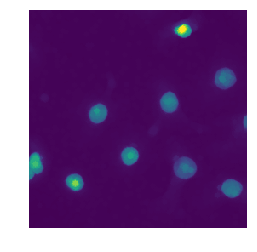

In [78]:
features = np.array([img[:, :, i] for i in range(2, 6)])
plt.imshow(features[3])
plt.axis('off')
plt.show()

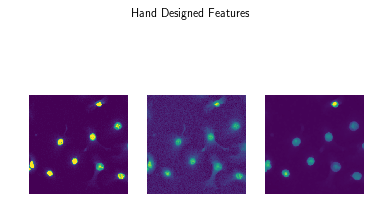

In [64]:
from deton8.visualization import plot_grid

fig = plot_grid(features, gridsize=(1, 3), title="Hand Designed Features")

#### bilateral filter

We first take the average of the image channels and then compute a pixel's deviation from the overall mean divided by the overall standard deviation.  Observe some images below.

Text(0.5,1,'bilateral filter')

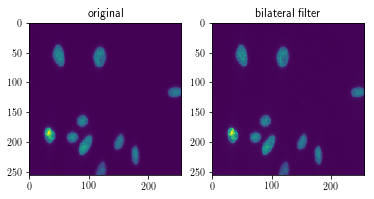

In [17]:
plt.subplot(121)
plt.imshow(img[:, :, 2])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 1])
plt.title("bilateral filter")

We chose to include this feature as it provides a clear contrast between light pixels which represent nuclei and the background of the image.

#### image rescaling

A bilateral filter is an edge preserving filter that reduces noise in an image.  We chose to include this filter because it will preserve the edges of our nuclei while smoothing brightness into somewhat darker areas of the nuclei.

Text(0.5,1,'50/99 Rescaling')

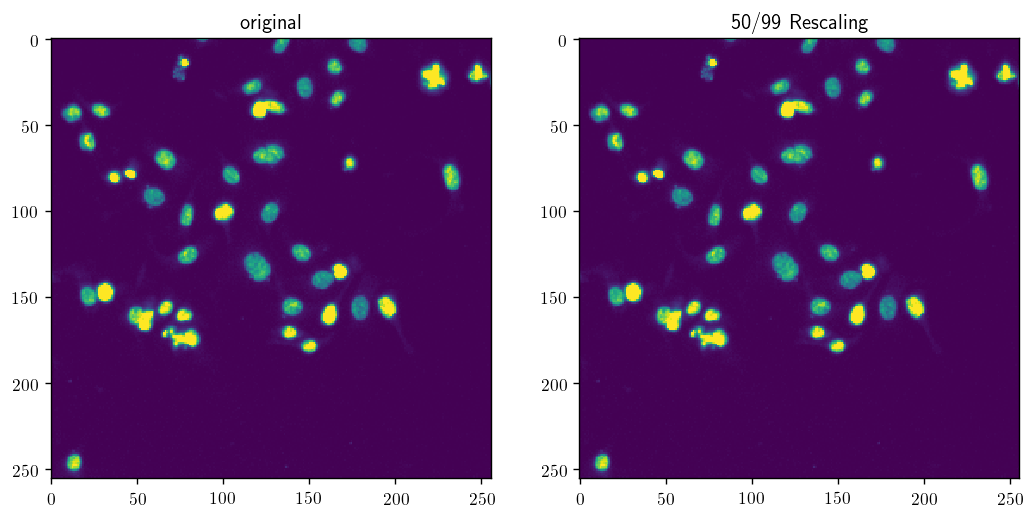

In [186]:
plt.subplot(121)
plt.imshow(img[:, :, 2])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 2])
plt.title("50/99 Rescaling")

#### histogram equalization

This feature takes the 2nd and 98th percentile of an image and rescales the values to be in this range.  The effect is an increase of 
contrast, since all values from the 98th to the 100th percentile are set to the maximum value and all values from the 0th to the 2nd percentile are set to the minimum value.  It also stretches the values inside the 2nd to 98th percentile a bit.  As we can see, the effect is quite desirable.  Our true nuclei are amplified, and noise around the nuclei isn't too drastically.

Text(0.5,1,'CL AHE')

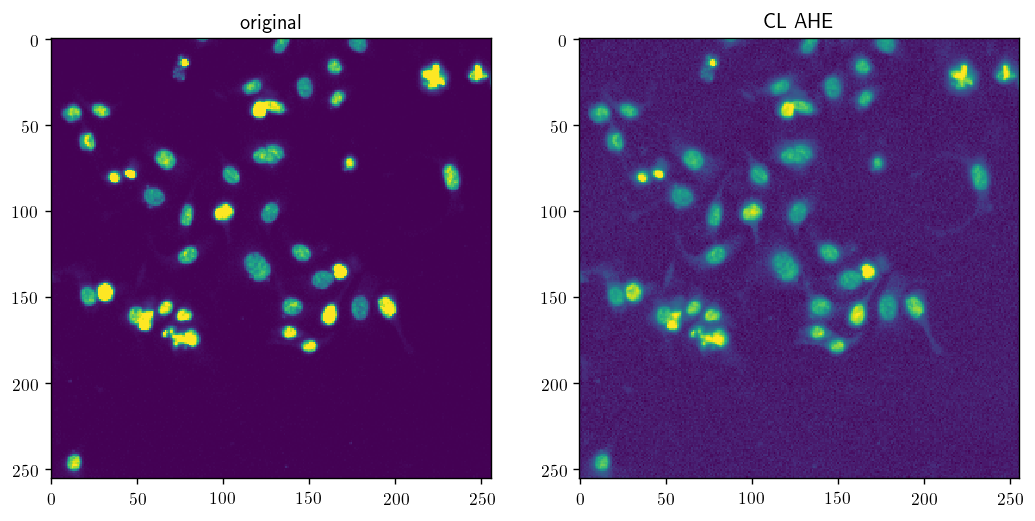

In [185]:
plt.subplot(121)
plt.imshow(img[:, :, 2])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 3])
plt.title("CL AHE")

#### DILATION

This feature performs a Contrast Limited Adaptive Histogram Equalization, which is quite a mouthful.  Conceptually we can think of this method as performing a sort of local rescaling -- which is quite attractive to us.  We increase the contrast in a local region rather than a global region, which will exclude that large portion of background "zeros".  The "Contrast Limited" portion takes the adaptive (local) histogram and will "clip" bins at a certain threshold, redistributing weight to the other bins equally.  Refer to [this wikipedia article](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) for more details.

Text(0.5,1,'Dilation')

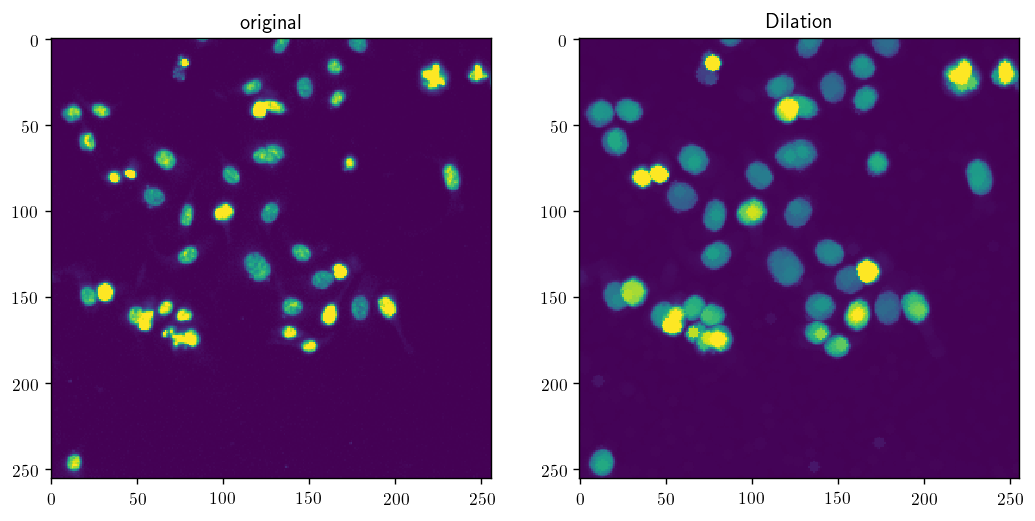

In [181]:
plt.subplot(121)
plt.imshow(img[:, :, 2])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 4])
plt.title("Dilation")

### Training

We have 670 images in our training set and we resize each image to be 256 x 256.  Since we're simply training our models with our basis transformed pixels, we have 670 * 256 * 256 points at this point in our training task.  Since this is over 43 million data points, we're not going to be able to train this dataset at once, so we'll have to rely on online, or mini-batch learning.  

So, we've restricted ourselves to two regressors from `scikit-learn`, the `SGDRegressor` using an elastic net penalty, and the `PassiveAggressiveRegressor`.  Both regressors support mini-batch learning.

We chose to frame this problem as a regression problem so we predict "probabilities" and then perform the local thresholding to determine how to binarize ourselves.

In [11]:
from deton8.utils import flatten_data

y_dev = y_train[::10]

x_dev_flat = flatten_data(x_dev)
x_val_flat = flatten_data(x_val)
y_dev_flat = flatten_data(y_dev)
y_val_flat = flatten_data(y_val)

In [12]:
from deton8.models import MiniBatchRegressor
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor
from tqdm import tqdm_notebook as tqdm

sgd_regressor = MiniBatchRegressor(
    regressor=SGDRegressor(penalty='elasticnet', l1_ratio=0.11),
    batch_size=1000,
    num_iters=50000,
    tqdm=tqdm
)

sgd_regressor.fit(x_dev, y_dev)

/home/will/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


MiniBatchRegressor(batch_size=1000, num_iters=50000,
          regressor=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.11, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          tqdm=<function tqdm_notebook at 0x7f1336626400>, verbose=False)

In [13]:
pa_regressor = MiniBatchRegressor(
    regressor=PassiveAggressiveRegressor(C=.1),
    batch_size=1000,
    num_iters=50000,
    tqdm=tqdm
)

pa_regressor.fit(x_dev, y_dev)

/home/will/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


MiniBatchRegressor(batch_size=1000, num_iters=50000,
          regressor=PassiveAggressiveRegressor(C=0.1, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive',
              max_iter=None, n_iter=None, random_state=None, shuffle=True,
              tol=None, verbose=0, warm_start=False),
          tqdm=<function tqdm_notebook at 0x7f1336626400>, verbose=False)

In [20]:
np.savez("../weights/regressor_weights.npz", sgd = sgd_regressor.regr_.coef_, pa = pa_regressor.regr_.coef_)

In [45]:
from deton8.visualization import plot_prediction

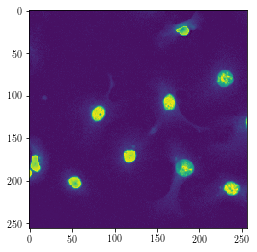

In [93]:
plt.imshow(sgd_regressor.predict(x_val[16]))
plt.show()

In [95]:
Image.fromarray(pa_regressor.predict(x_val[16])).convert('RGB').save("../poster/figs/pa_output.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


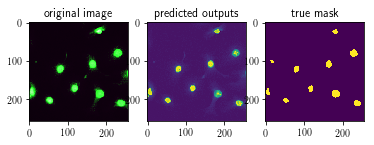

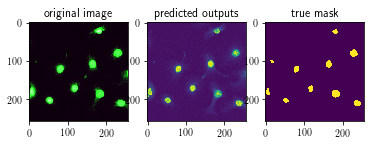

In [47]:
num = 16
plot_prediction(pa_regressor, x_val[num], y_val[num])
plot_prediction(sgd_regressor, x_val[num], y_val[num])

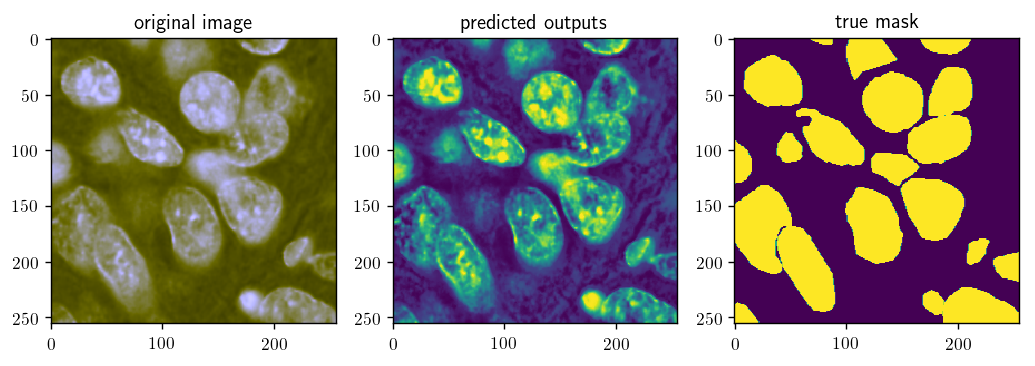

In [166]:
num = 31
plot_prediction(sgd_regressor, x_val[num], y_val[num])

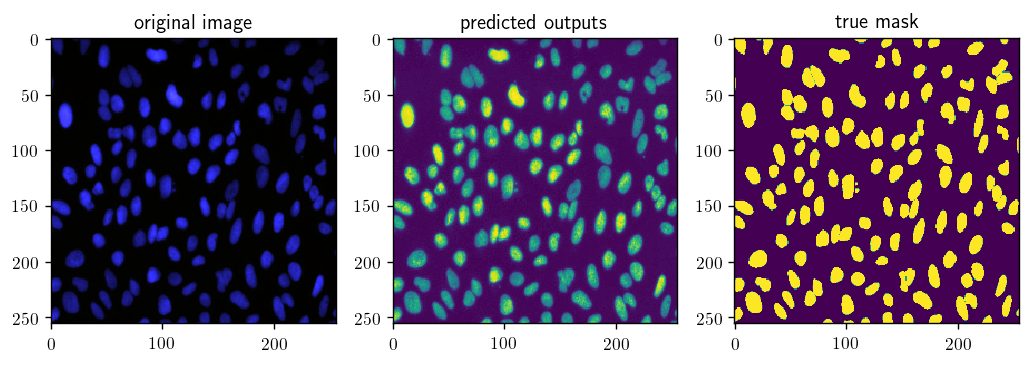

In [167]:
num = 9
plot_prediction(sgd_regressor, x_val[num], y_val[num])

As we can see, our model seems to perform well across data modalities, one of our initial fears.  While the high degree of noise in the image above resulted in large noise in the predicted image, we're confident in our post-processing and segmentation code to only select the areas of interest.  Let's take a look at our **pixel F1** scores using naive global thresholds to binarize our image.  Note that this has nothing to do with the competition metric, which is much more involved.